In [17]:
# Paquetes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from scipy.integrate import solve_ivp

Queremos resolver el problema 
$$
\begin{cases}
\frac{\partial r(t)}{\partial t} &= -L_\sigma(r(t)) \\
r(0) &= r_0
\end{cases}
$$
donde 
$$
L_\sigma(r(t)) = \frac{1}{ND^2} \sum_{i=1}^N (\sigma(r + D_i)(D_i)
$$
con $D_i$ vectores constantes fijos tal que $\sum_{i=1}^N D_i = 0$.

In [18]:
epsilon = 0.001
def L_sigma(t, r, sigma, D, verbose=False):
    grad = sum([sigma((r + di)[0], (r + di)[1])*(di) for di in D]) # / (len(D) * len(D)**2) 
    if np.linalg.norm(grad) > epsilon:
        grad /= np.linalg.norm(grad)
    return -grad
    
def r(L, r0, t0, tf, Npoints=None):
    """
    Devuelve la función r(t) solución del problema anterior. Donde
        - r0: Es el vector de posición inicial de r (Centro del enjambre).
        - L:  Es una función L(t) tal que para cada posición nos 
              devuelve el valor de L.
        - t0: Tiempo inicial. 
        - tf: Tiempo final.
        - Npoints: Número de puntos de para calcular r(t) si no le damos ninguno
                    cálcula como np.abs(tf-t0)*10
    """
    Npoints = np.abs(tf-t0)*10 if Npoints is None else Npoints
    t_eval = t_eval=np.linspace(t0,tf,Npoints)
    
    # Devolvemos la solución del problema
    # solve_ivp hace algo parecido a ode45 en Matlab
    return solve_ivp(L, (t0, tf), r0, t_eval=t_eval)
    

In [19]:
# Parámetros a modificar
sigma = lambda x, y: -10*(np.exp((-x**2-y**2)/100)) # Función a optimizar
# sigma = lambda x,y: (x**2 + 3*x**2 * y**2 - x*y + 8*y**2)

N = 6 # Número de robots
r_c0 = np.array([7, -12]) # Centro del enjambre de robots inicial aproximado

# Indica si queremos información del gradiente
verbose=True

D_mean = 0.1 # Elegimos media de distancia al centro del enjambre
desv = 0.5 # Elegimos desviación típica de esta distancia
desv_ang = np.pi/4 # Elegimos desv. tipica ángulos

# Calculamos los D (distancias al centro)
D = []
for i in range(N):
    phi = np.random.normal(loc=0, scale=desv_ang, size=None) + 2*np.pi * i / N # Elegimos el ángulo rotado respecto al centro del círculo
    D_random = np.random.normal(loc=D_mean, scale=desv, size=None) # Calculamos el radio de este robot
    D.append(D_random*np.array([np.cos(phi), np.sin(phi)]))
              
# Ajustamos los D para que sum_i=1^N valga 0, es decir, le quitamos la media
D = [di - np.array(D).sum(axis=0) / N for di in D]
# Resolución del problema
# Planteamos L del problema: L(t, r(t))
L = lambda t, r: L_sigma(t, r, sigma, D)

# Calculamos la solución del problema con la función r 
sol = r(L, r_c0, t0=0, tf=500)

t = sol.t
x = sol.y[0]
y = sol.y[1]

# Gráficos
    - 1. Trayectoria
    - 2. Trayectoria 3D (Sólo el centro)
    - 3. Campo vectorial generado por L(t, r(t)) (Notar que usamos t=0 ya que es independiente de t)

In [20]:
# Gráficos de las trayectorias
# Ploteamos la trayectoria de los centros
plt.plot(x[0], y[0], 'ro', markersize=6)
plt.plot(x, y,'b', alpha=0.5, linewidth=2)
plt.plot(x[-1], y[-1], 'o', markersize=6, color='darkblue')

# Ploteamos la trayectoria de los robots
for di in D:
    plt.plot(x[0] + di[0], y[0] + di[1], 'yo', markersize=3)
    plt.plot(x + di[0], y + di[1],'b', alpha=0.2, linewidth=1)
    plt.plot(x[-1] + di[0], y[-1] + di[1], 'co', markersize=3)

# Ajustamos los ejes
plt.xlim([-2, 15])
plt.ylim([-15, 2])

# Ajustamos el grid y los hacemos display de los ejes
plt.grid(True, which='both')
plt.axhline(y=0, color='k', linewidth=1)
plt.axvline(x=0, color='k', linewidth=1)

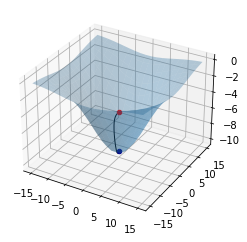

In [21]:
# Para la función exponencial queda más bonito:
# Para la exp es mejor esta theta que lo deja 'abierto por un el lado bien'
# theta = np.linspace(-0.9 * np.pi, 0.8 * np.pi, 40)
#R = np.linspace(0, 15, 20)
# theta = np.linspace(-np.pi, np.pi, 40)
# R, theta = np.meshgrid(R, theta)
# X = R * np.sin(theta)
# Y = R * np.cos(theta)
X, Y = np.meshgrid(np.linspace(-15, 15, 20), np.linspace(-15, 15, 20))
Z = sigma(X, Y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.3)

ax.scatter3D(r_c0[0], r_c0[1], sigma(*r_c0), c='r', alpha=1)
ax.plot(x, y, sigma(x, y), 'k', linewidth=1, markersize=0.1)
ax.scatter3D(x[-1], y[-1], sigma(x[-1],y[-1]), c='darkblue', alpha=1)

In [22]:
# 2. Dibujamos el campo vectorial generado por L, el color rojo se corresponde con el mínimo
# Como vemos siempre apuntamos al mínimo
X,Y = np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10))
u = np.zeros(X.shape)
v = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        u[i,j], v[i,j]  = L(0, np.array([X[i,j], Y[i,j]]))

plt.quiver(X,Y,u,v)
plt.plot(0, 0, 'ro')
plt.grid(True, which='both')
#plt.axhline(y=0, color='k', linewidth=1)
#plt.axvline(x=0, color='k', linewidth=1)
